In [10]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src")
from main import Country

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# country that is attacked
country_name = "Germany" 

# nuclear arsenal with which the country is attacked (number of warheads and yield in kt)
arsenal = 200*[100] 

In [12]:
country = Country(country_name)

# sanity check - this corresponds to the population of the selected country
country.data.sum() 

LandScan TIF file loaded successfully.


84345835

In [16]:
country.attack_max_fatality_non_overlapping(arsenal, include_injuries=True)

In [17]:
country.get_total_fatalities()

41834144


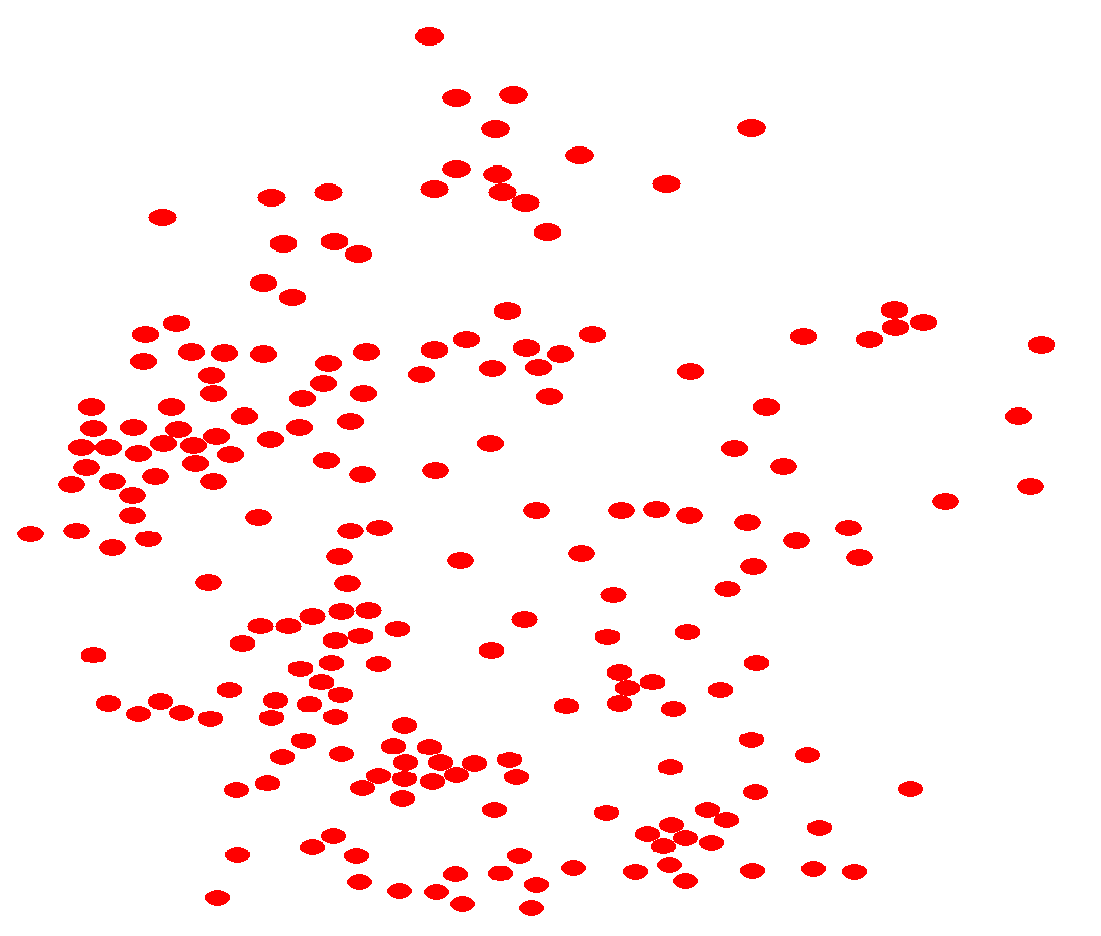

In [15]:
m = country.plot(show_hit_regions=True, show_population_density=False)
m